For this challenge, I will be attempting to predict the arrival delay time using a regression model. 

The first thing we want to do is download the data from http://transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time. I will start with just the January 2015 data. Since the data is fairly small in size, I just took all the data. 

In [1]:
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('data.csv')

Next, I eliminated the features/columns with too much missing data. Even though such features might contain useful information, there is simply not enough data on them to result in a model with accurate generalization. The threshold that I used is 90%. I also removed any observations in which the arrival delay data is missing, since this is not helpful for training the model. In fact, as we will see later, these missing values for arrival delay are actually for cancelled/diverted flights.

In [3]:
import math

columnsToRemove = []
for i in range(len(df.columns)):
    numMissing = sum(pd.isnull(df.ix[:,i]))
    if (numMissing / float(len(df.index))) > 0.9:
        columnsToRemove.append(i)
namesToRemove = [df.columns.values[i] for i in columnsToRemove]
print namesToRemove  
df = df[df.ARR_DELAY.notnull()]

['CANCELLATION_CODE', 'FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME', 'DIV_REACHED_DEST', 'DIV_ACTUAL_ELAPSED_TIME', 'DIV_ARR_DELAY', 'DIV_DISTANCE', 'DIV1_AIRPORT', 'DIV1_AIRPORT_ID', 'DIV1_AIRPORT_SEQ_ID', 'DIV1_WHEELS_ON', 'DIV1_TOTAL_GTIME', 'DIV1_LONGEST_GTIME', 'DIV1_WHEELS_OFF', 'DIV1_TAIL_NUM', 'DIV2_AIRPORT', 'DIV2_AIRPORT_ID', 'DIV2_AIRPORT_SEQ_ID', 'DIV2_WHEELS_ON', 'DIV2_TOTAL_GTIME', 'DIV2_LONGEST_GTIME', 'DIV2_WHEELS_OFF', 'DIV2_TAIL_NUM', 'DIV3_AIRPORT', 'DIV3_AIRPORT_ID', 'DIV3_AIRPORT_SEQ_ID', 'DIV3_WHEELS_ON', 'DIV3_TOTAL_GTIME', 'DIV3_LONGEST_GTIME', 'DIV3_WHEELS_OFF', 'DIV3_TAIL_NUM', 'DIV4_AIRPORT', 'DIV4_AIRPORT_ID', 'DIV4_AIRPORT_SEQ_ID', 'DIV4_WHEELS_ON', 'DIV4_TOTAL_GTIME', 'DIV4_LONGEST_GTIME', 'DIV4_WHEELS_OFF', 'DIV4_TAIL_NUM', 'DIV5_AIRPORT', 'DIV5_AIRPORT_ID', 'DIV5_AIRPORT_SEQ_ID', 'DIV5_WHEELS_ON', 'DIV5_TOTAL_GTIME', 'DIV5_LONGEST_GTIME', 'DIV5_WHEELS_OFF', 'DIV5_TAIL_NUM', 'Unnamed: 109']


Next, I removed some redundant features that are sufficiently replicated by other variables (most or all of the information in one variable is contained in the others):

In [4]:
redundantColNames = ['FL_DATE', 'CARRIER', 'ORIGIN_AIRPORT_SEQ_ID', 
                     'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
                     'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_SEQ_ID',
                     'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS',
                     'DEST_STATE_NM', 'DEST_WAC', 'CRS_DEP_TIME', 'DEP_TIME',
                     'DEP_DEL15', 'DEP_DELAY_GROUP', 'CRS_ARR_TIME', 
                     'ARR_TIME', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP',
                     'DISTANCE_GROUP', 'YEAR', 'QUARTER', 'MONTH', 'FLIGHTS']
namesToRemove.extend(redundantColNames)

One thing to note is that ARR_DELAY_NEW was removed as a potential output variable and ARR_DELAY will be used instead. For regression, it may be the case that using ARR_DELAY_NEW would actually yield better performance, but I did not test this due to time constraints.

In order for our model to be useful, it should only incorporate features that can be known before the flight happens. It should not, for example, include features in the data such as departure delay, weather delay, or wheels off time, otherwise that defeats the point of the prediction. Therefore, I removed all such features:

In [5]:
nonIndependentColNames = ['DEP_DELAY', 'DEP_DELAY_NEW', 'WHEELS_OFF', 
                          'WHEELS_ON', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
                          'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
                          'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
namesToRemove.extend(nonIndependentColNames)

Now we look at the features of our reduced dataset:

In [6]:
for colName in namesToRemove:
    df.drop(colName, axis=1, inplace=True)

delays = df['ARR_DELAY']
df.drop('ARR_DELAY', axis=1, inplace=True)
print (df.columns.values)

['DAY_OF_MONTH' 'DAY_OF_WEEK' 'UNIQUE_CARRIER' 'AIRLINE_ID' 'TAIL_NUM'
 'FL_NUM' 'ORIGIN_AIRPORT_ID' 'ORIGIN_CITY_MARKET_ID' 'ORIGIN'
 'DEST_AIRPORT_ID' 'DEST_CITY_MARKET_ID' 'DEST' 'DEP_TIME_BLK' 'TAXI_OUT'
 'TAXI_IN' 'ARR_TIME_BLK' 'CANCELLED' 'DIVERTED' 'CRS_ELAPSED_TIME'
 'DISTANCE' 'DIV_AIRPORT_LANDINGS']


Unfortunately, scikit-learn doesn't natively handle categorical/discrete variables. Therefore, there will have to be a bit more preprocessing done on the data. The most common way to encode categorical variables is to incorporate k dummy variables, where k is the number of levels for the variable. Each level is then encoded as a binary indicator variable (often, one of these dummy variables is removed to reduce multicollinearity, resulting in k-1 dummy variables). However, this poses a bit of a problem when the number of levels is large, as we can see below. Listed below is each categorical variable along with the number of levels it has:

In [7]:
from collections import Counter

discrete_features = ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 
                     'AIRLINE_ID', 'TAIL_NUM', 'FL_NUM', 'ORIGIN_AIRPORT_ID', 
                     'ORIGIN_CITY_MARKET_ID', 'ORIGIN', 'DEST_AIRPORT_ID', 
                     'DEST_CITY_MARKET_ID', 'DEST', 'DEP_TIME_BLK', 'ARR_TIME_BLK',
                     'CANCELLED', 'DIVERTED']
for feature in discrete_features:
    numLevels = len(Counter(df[feature].values))
    print "%s: %d" % (feature, numLevels)

DAY_OF_MONTH: 31
DAY_OF_WEEK: 7
UNIQUE_CARRIER: 14
AIRLINE_ID: 14
TAIL_NUM: 4394
FL_NUM: 6334
ORIGIN_AIRPORT_ID: 312
ORIGIN_CITY_MARKET_ID: 291
ORIGIN: 312
DEST_AIRPORT_ID: 312
DEST_CITY_MARKET_ID: 291
DEST: 312
DEP_TIME_BLK: 19
ARR_TIME_BLK: 19
CANCELLED: 1
DIVERTED: 1


First, it is clear that we don't need cancelled or diverted as variables anymore (we eliminated all such flights when removing N/A arrival delay observations). Next, let's see if some of the other variables are actually significant in predicting arrival delay. I plotted the average arrival delay for each level for 'ORIGIN_AIRPORT_ID' and 'DEST_AIRPORT_ID'.

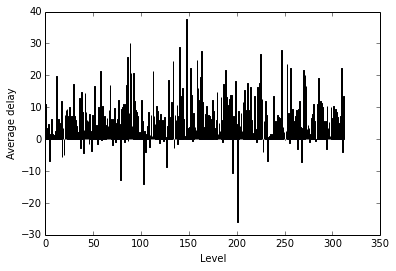

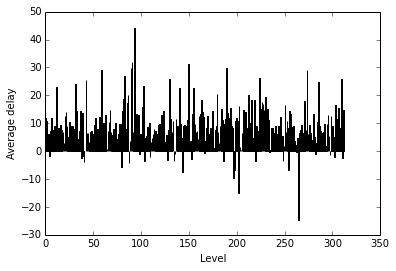

In [8]:
import matplotlib.pyplot as plt

y = delays.values
def plotFeatureRelationshipGraph(df, feature):
    featureValues = df[feature].values
    frequencies = Counter(featureValues)
    averages = []
    for level in frequencies:
        featureValuesForLevel = [y[i] for i in range(0, len(featureValues)) 
                                 if featureValues[i] == level]
        averages.append(np.average(featureValuesForLevel))
    plt.xlabel('Level')
    plt.ylabel('Average delay')
    plt.bar(range(len(frequencies)), averages)
    plt.show()
plotFeatureRelationshipGraph(df, 'ORIGIN_AIRPORT_ID')   
plotFeatureRelationshipGraph(df, 'DEST_AIRPORT_ID')   
        

From the graphs, it seems that there are certain origin and destination airports that stand out from the others. Therefore, it is not evident that we can just eliminate these features -- indeed, intuitively, it is not surprising that certain airports are more timely than others.  

Given more time, it might be useful to look in-depth into these 2 variables, as well as into others such as TAIL_NUM and FLIGHT_NUM. For example, after creating the dummy binary indicator variables from these categorical variables it could be very useful to perform some feature selection. This can be done in a variety of ways -- for example, we can use LASSO to apply variable selection, or use the relative importance nubmers of random forest. We can also apply machine learning dimensionality reduction methods like PCA.

For the time being, let us just create dummy variables for the following categorical variables: DAY_OF_MONTH, DAY_OF_WEEK, UNIQUE_CARRIER, AIRLINE_ID, ORIGIN_AIRPORT_ID, DEST_AIRPORT_ID, DEP_TIME_BLK, ARR_TIME_BLK.

In [13]:
final_cat_vars = ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'AIRLINE_ID', 
                  'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DEP_TIME_BLK', 'ARR_TIME_BLK']
for feature in final_cat_vars:
    dummy = pd.get_dummies(df[feature], feature, '-')
    dummy.drop(dummy.columns[0], axis=1, inplace=True)
    df.drop(feature, axis=1, inplace=True)
    df = pd.concat([df, dummy], axis=1)
    
features_to_remove = ['TAIL_NUM', 'FL_NUM', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN', 
                      'DEST_CITY_MARKET_ID', 'DEST', 'CANCELLED', 'DIVERTED', 
                      'DIV_AIRPORT_LANDINGS']
for feature in features_to_remove:
    df.drop(feature, axis=1, inplace=True)

Now we can implement a crude variable selection method. I've done this by using an elastic net model, which tries to identify the most important variables via shrinkage. I've tuned it with an alpha value of 0.5 (equal split between LASSO and ridge regression). Below are the variables selected.

In [33]:
from sklearn.linear_model import ElasticNet

X = np.array(df)
y = delays.values
enet_model = ElasticNet(alpha=0.5)
trained_enet = enet_model.fit(X, y)

coefs = trained_enet.coef_
selected_var_indices = [i for i in range(len(coefs)) if abs(coefs[i]) > 0.0001]
print [df.columns.values[i] for i in selected_var_indices]

['TAXI_OUT', 'TAXI_IN', 'CRS_ELAPSED_TIME', 'DISTANCE', 'DAY_OF_MONTH-3', 'DAY_OF_MONTH-4', 'DAY_OF_MONTH-5', 'DAY_OF_MONTH-6', 'DAY_OF_MONTH-12', 'DAY_OF_MONTH-27', 'DAY_OF_MONTH-28', 'DAY_OF_WEEK-3', 'DAY_OF_WEEK-4', 'DAY_OF_WEEK-7', 'UNIQUE_CARRIER-DL', 'UNIQUE_CARRIER-MQ', 'UNIQUE_CARRIER-US', 'UNIQUE_CARRIER-WN', 'AIRLINE_ID-19790', 'AIRLINE_ID-20355', 'AIRLINE_ID-20398', 'ORIGIN_AIRPORT_ID-13930', 'DEST_AIRPORT_ID-10397', 'DEP_TIME_BLK-0600-0659', 'DEP_TIME_BLK-0700-0759', 'DEP_TIME_BLK-0800-0859', 'DEP_TIME_BLK-0900-0959', 'DEP_TIME_BLK-1700-1759', 'DEP_TIME_BLK-1800-1859', 'ARR_TIME_BLK-0800-0859', 'ARR_TIME_BLK-0900-0959', 'ARR_TIME_BLK-1000-1059', 'ARR_TIME_BLK-2000-2059']


Now we can build a baseline model for the data. In the past, there has been work done on the topic of flight delay predictions. In particular, the winners of a crowdsourcing competition, Flight Quest 1 (http://www.gequest.com/c/flight), used a combination of gradient boosting  and random forest models. The nice thing about these 2 models is that they can also handle N/A values in our data. Therefore, I will implement these 2 baseline models:

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import cross_validation

X = X[:, selected_var_indices]
gbm_model = GradientBoostingRegressor(n_estimators=25)
cross_val_results = cross_validation.cross_val_score(gbm_model, X, y, cv=5, scoring='mean_squared_error',
                                                     n_jobs=-1)
print cross_val_results

[-1639.81531452 -1581.62279598 -1288.29123898  -726.01043679 -1691.03110372]


To test the generalization performance, I did 5-fold cross-validation on the results obtained by the gradient boosting model. Across the 5 folds, the average MSE is 1385 (note that the MSE values have their signs flipped due to an implementation detail in scikit-learn). These predictions really are not so good, as they are not much better than the constant mean predictor. Still, it gives us a foundation to build upon, and there are many avenues for exploration, which are detailed at the end. 

In [43]:
print np.var(y)  # Total MSE of the mean predictor

1553.42064056


In [41]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=25)
cross_val_results = cross_validation.cross_val_score(rf_model, X, y, cv=5, scoring='mean_squared_error')
print cross_val_results

[-1822.31127517 -1769.93161278 -1427.69621529  -860.47179045 -1842.30130465]


Again, the results are not particularly impressive, with an average MSE of 1544.

In the above 2 models, I've only implemented 2 out-of-the-box models with mostly default parameters. In fact, I am using a very low number of estimators to make the prediction, which explains the somewhat poor cross-validated results. It is immensely helpful to tune parameters such as n_estimators and max_features, as well as use a higher n_estimators value. In particular, ensemble models such as Gradient Boosting and Random Forests are known to perform quite poorly if there are a few number of trees/estimators. However, such tasks require greater processing power (and more time) than available on my local machine, and would ideally be run on a cluster. For the purposes of the current project, I have not done this.

I have not done any special imputation for this problem, and it may be worthwhile to implement a default imputation method using the median/mode of a column to impute values.

It is also clear that one might try many more than 2 models, in order to get a good sense of how models compare to one another. On a similar note, using an meta-ensemble model that can for example combine our GBM and RF predictions into an even stronger one has often been shown to be helpful. For instance, Wolpert's stacked generalization/stacking (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.56.1533&rep=rep1&type=pdf) paper details an excellent ensemble model that has been used by many in practice, and was prominently featured in the Netflix Prize competition. 

It could also be useful to think about encoding some variables that we already know have significant information. An example of this would be to introduce an IS_HOLIDAY variable or NEAR_HOLIDAY variable to indicate if a particular date is close to a major US holiday. It is quite clear that delays tend to be higher on such dates due to a spike in demand for flying. In addition, inclemenet weather is often a huge contributor to delays. Perhaps mining some historical weather information and augmenting it with the dataset could result in some interesting observations.

Finally, all this modeling has been done on the January 2015 dataset only. Certainly, flight patterns vary throughout the year and across the years, so looking at historical data can lead to better generalization due to the increased training data size, as well as being able to incorporate month information.

In conclusion, these initial baseline models are quite crude and there is a lot to be improved upon. The avenues suggested above would be interesting to explore later on, given the time.